# Лабораторная работа №4

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/11600OkqdRzxc-xZmFTuBs099VeAqU_GlE0Bx6bBlIRE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Пример импорта данных. Грузим данные

In [263]:
import pandas as pd
import numpy as np
import torch
import chardet
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Normalize, Lambda
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


In [264]:

path = '../LR2/spotify-2023.csv'
with open(path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

data = pd.read_csv(path, encoding=encoding)
data = data.drop(574)
data = data.dropna()

In [293]:
selected_features = [
    'artist_count',
    'released_year',
    'released_day',
    'released_month',
    # 'streams',
    'in_apple_playlists',
    'valence_%',
    'bpm',
    'energy_%'
]

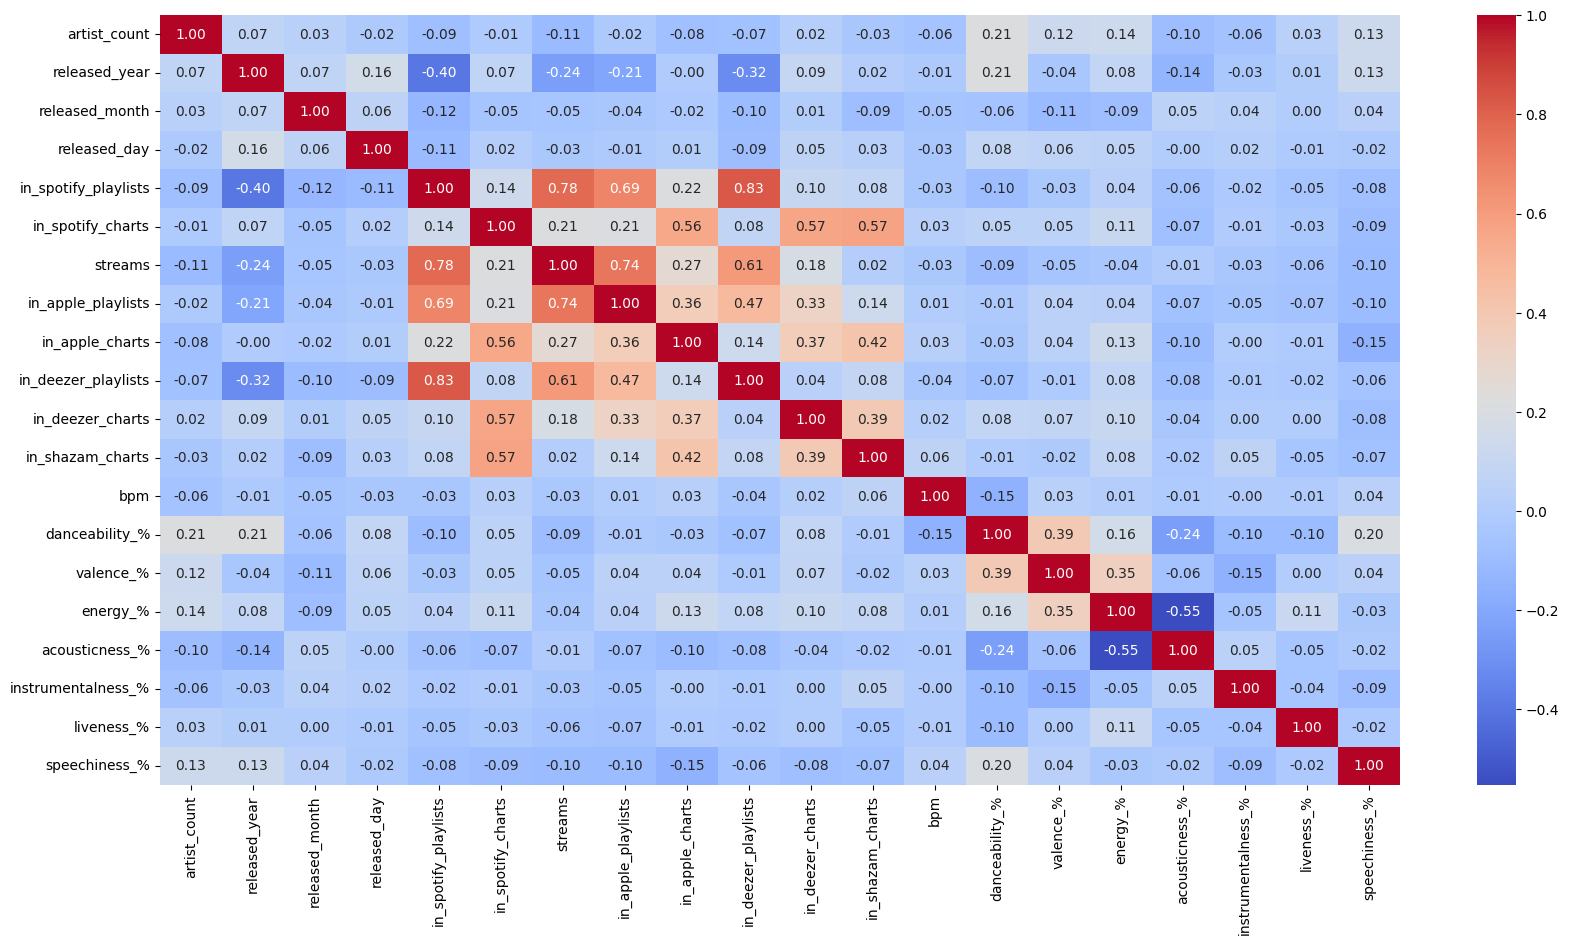

In [295]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feat = ['artist_count', 'released_year',
           'released_month', 'released_day', 'in_spotify_playlists',
           'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
           'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%',
           'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
selected_df = data[feat]
selected_df_copy = selected_df.copy()
for col in selected_df_copy.columns:
    selected_df_copy[col] = selected_df_copy[col].replace(',', '', regex=True).astype(float)

corr_matrix = selected_df_copy.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:

selected_features = [
    'artist_count',
    'released_year',
    'released_day',
    'released_month',
    # 'streams',
    'in_apple_playlists',
    'valence_%',
    'bpm',
    # 'energy_%'
]
target_variable = 'danceability_%'
X = data[selected_features]
for feature in selected_features:
    X[feature] = X[feature].astype(float)
Y = data[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [311]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[selected_features])

X_test_scaled = scaler.transform(X_test[selected_features])

X.loc[X_train.index, selected_features] = X_train_scaled
X.loc[X_test.index, selected_features] = X_test_scaled




In [324]:
import torch
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader


class SpotifyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = SpotifyDataset(X_train.values, y_train.values, )
test_dataset = SpotifyDataset(X_test.values, y_test.values,)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [344]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out



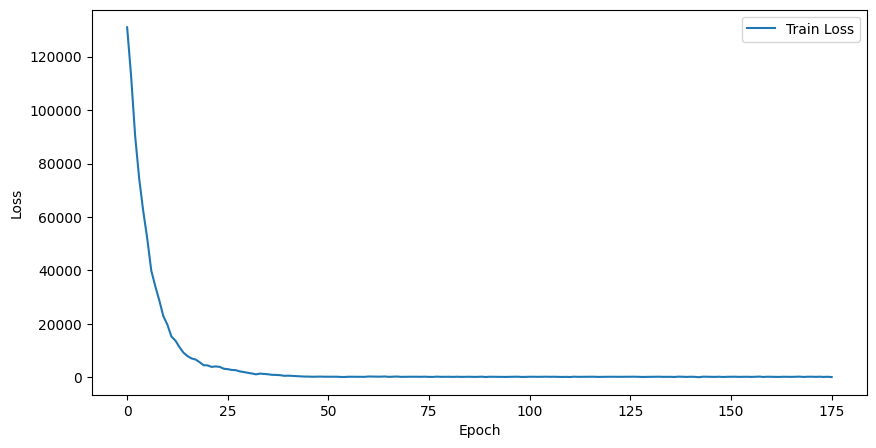

In [356]:
lossess_array = []
model1 = Model1(len(selected_features), 10, 1)  # 50 - размер скрытого слоя
optimizer = optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()
for epoch in range(20):
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lossess_array.append(loss.item())
    
    if epoch % 5 == 0:  
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.plot(lossess_array, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [353]:

criterion = torch.nn.MSELoss()
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out




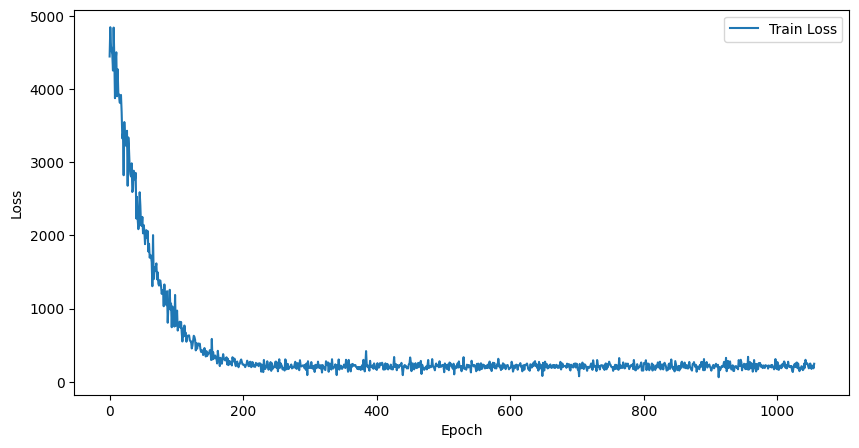

In [354]:
model2 = Model2(len(selected_features), 100, 1)  # 50 - размер скрытого слоя
optimizer = optim.Adam(model2.parameters(), lr=0.01)
lossess_array = []
for epoch in range(100):  
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lossess_array.append(loss.item())
        
    if epoch % 5 == 0:  
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.plot(lossess_array, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [333]:

class Model3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out


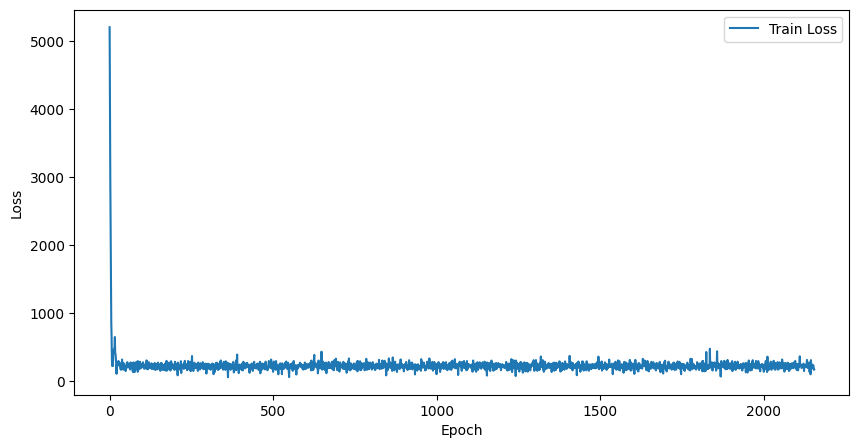

In [357]:
model3 = Model3(len(selected_features), 50, 1)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
lossess_array = []
for epoch in range(200):
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lossess_array.append(loss.item())
        
    if epoch % 5 == 0: 
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.plot(lossess_array, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [358]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error,  mean_squared_error
def GetMetrics(model):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test.values, dtype=torch.float32)).numpy()
        RMSE = np.sqrt(mean_squared_error(y_test.values, y_pred))
        MAE  = mean_absolute_error(y_test.values, y_pred)
        MAPE = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100
        print(f"MAPE: {MAPE:.2f}%")
        print(f"MAE: {MAE:.2f}")
        print(f"RMSE: {RMSE:.2f}")  


In [359]:
print(f"{'Модель 1':–^25}")
GetMetrics(model1)
print(f"{'Модель 2':–^25}")
GetMetrics(model2)
print(f"{'Модель 3':–^25}")
GetMetrics(model3)

––––––––Модель 1–––––––––
MAPE: 22.58%
MAE: 12.38
RMSE: 15.16
––––––––Модель 2–––––––––
MAPE: 22.63%
MAE: 12.37
RMSE: 15.03
––––––––Модель 3–––––––––
MAPE: 22.23%
MAE: 12.26
RMSE: 14.77
